WHy does the cosine-cosine combination in the Embedding+Clustering algorithm protocol outperform every other combination?
One thought was that intrinsic dimensionality was lower for cosine than embeddings generated using dot or euclidean and that makes it easier to be identifiable?

In [1]:
import numpy as np

def compute_effective_rank(X):
    """
    Computes the effective rank of the dataset X.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Data matrix of shape (n_samples, n_features).
        
    Returns:
    --------
    effective_rank : float
        The effective rank computed using the Shannon entropy of the normalized eigenvalues.
    """
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    
    # Compute the covariance matrix
    cov_matrix = np.cov(X_centered, rowvar=False)
    
    # Eigenvalue decomposition of the covariance matrix
    eigenvalues = np.linalg.eigvalsh(cov_matrix)
    
    # Ensure numerical stability by removing any negative eigenvalues (if any)
    eigenvalues = np.maximum(eigenvalues, 0)
    
    # Normalize the eigenvalues to get a probability distribution
    total_variance = np.sum(eigenvalues)
    if total_variance == 0:
        raise ValueError("Total variance is zero; cannot compute effective rank.")
    p = eigenvalues / total_variance
    
    # Compute the effective rank using the Shannon entropy formula
    # Adding a small constant to avoid log(0)
    effective_rank = np.exp(-np.sum(p * np.log(p + 1e-12)))
    
    return effective_rank

In [2]:
np.random.seed(42)
X = np.random.randn(1000, 64)

# Compute and print the effective rank
rank = compute_effective_rank(X)
print("Effective Rank:", rank)

Effective Rank: 61.98788147473849


Now load in the embeddings we generated to create a plot of this

In [41]:
import numpy as np
import pandas as pd
import pickle
from scipy import sparse
import matplotlib.pyplot as plt
from tqdm import tqdm

def load_net_and_embedding(net_filename, comm_filename, emb_filename):
    net = sparse.load_npz(net_filename)
    community_table = pd.read_csv(comm_filename)
    with open(emb_filename, 'rb') as f:
        emb_dict = pickle.load(f)
    return net, community_table, emb_dict

def process_run(run_no, mu, K):
    path_name = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_n2v_metric_change_10000_{K}_3.0_minc50/Run_{run_no}/"
    net_filename = path_name + f"net_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu}_k_{K}_mincomm_50.npz"
    comm_filename = path_name + f"community_table_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu}_k_{K}_mincomm_50.csv"
    emb_filename = path_name + f"embeddings_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu}_k_{K}_mincomm_50.pkl"
    
    net, community_table, emb_dict = load_net_and_embedding(net_filename, comm_filename, emb_filename)
    return net, community_table, emb_dict

def compute_effective_rank(X):
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    # Compute the covariance matrix
    cov_matrix = np.cov(X_centered, rowvar=False)
    # Eigenvalue decomposition (for symmetric matrices)
    eigenvalues = np.linalg.eigvalsh(cov_matrix)
    # Ensure eigenvalues are non-negative (numerical stability)
    eigenvalues = np.maximum(eigenvalues, 0)
    total_variance = np.sum(eigenvalues)
    if total_variance == 0:
        return 0
    # Normalize eigenvalues to form a probability distribution
    p = eigenvalues / total_variance
    # Compute effective rank using Shannon entropy
    effective_rank = np.exp(-np.sum(p * np.log(p + 1e-12)))
    return effective_rank

# Define the parameters
mu_values = np.round(np.arange(0.05, 1.05, 0.05), decimals=2)
K_values = [5, 10, 50]
embedding_types = ['dot', 'euclidean', 'cosine']
num_runs = 10

# List to store the raw results for every run.
raw_results = []

# Loop over each K, each mixing parameter mu, and each run, with tqdm for progress.
for K in tqdm(K_values, desc="Processing K values"):
    for i, mu in tqdm(enumerate(mu_values), total=len(mu_values), desc=f"Processing mu for K={K}"):
        for run_no in tqdm(range(1, num_runs + 1), desc=f"Processing runs for mu={mu}, K={K}", leave=False):
            try:
                _, _, emb_dict = process_run(run_no, mu, K)
                # If emb_dict is empty, record missing values for all embedding types.
                if not emb_dict:
                    tqdm.write(f"emb_dict empty for run {run_no} (mu={mu}, K={K}); marking as missing.")
                    for etype in embedding_types:
                        raw_results.append({
                            "K": K,
                            "mu": mu,
                            "run_no": run_no,
                            "embedding_type": etype,
                            "effective_rank": np.nan
                        })
                    continue
                for etype in embedding_types:
                    try:
                        # Assume emb_dict[etype] is a numpy array with shape (n_samples, embedding_dimension)
                        eff_rank = compute_effective_rank(emb_dict[etype])
                    except Exception as e:
                        tqdm.write(f"Error computing effective rank for run {run_no}, mu {mu}, K {K}, type {etype}: {e}")
                        eff_rank = np.nan
                    raw_results.append({
                        "K": K,
                        "mu": mu,
                        "run_no": run_no,
                        "embedding_type": etype,
                        "effective_rank": eff_rank
                    })
            except Exception as e:
                tqdm.write(f"Error processing run {run_no} for mu {mu} and K {K}: {e}")
                # Record missing values for all embedding types if process_run fails.
                for etype in embedding_types:
                    raw_results.append({
                        "K": K,
                        "mu": mu,
                        "run_no": run_no,
                        "embedding_type": etype,
                        "effective_rank": np.nan
                    })

# Convert raw_results into a DataFrame for further analysis
df_results = pd.DataFrame(raw_results)
print(df_results.head())

# Aggregate the results: compute mean, standard deviation, count and standard error for each combination.
agg_results = (
    df_results.groupby(["K", "mu", "embedding_type"])["effective_rank"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
agg_results["se"] = agg_results["std"] / np.sqrt(agg_results["count"])
print(agg_results.head())

Processing K values:   0%| | 0/3 [00:00<?
Processing mu for K=5:   0%| | 0/20 [00:0

Processing runs for mu=0.05, K=5:   0%| |

Processing runs for mu=0.05, K=5:  30%|▎|

Processing runs for mu=0.05, K=5:  60%|▌|

Processing runs for mu=0.05, K=5:  90%|▉|

                                         
Processing mu for K=5:   5%| | 1/20 [00:0

Processing runs for mu=0.1, K=5:   0%| | 

Processing runs for mu=0.1, K=5:  30%|▎| 

Processing runs for mu=0.1, K=5:  60%|▌| 

Processing runs for mu=0.1, K=5:  90%|▉| 

                                         
Processing mu for K=5:  10%| | 2/20 [00:0

Processing runs for mu=0.15, K=5:   0%| |

Processing runs for mu=0.15, K=5:  30%|▎|

Processing runs for mu=0.15, K=5:  60%|▌|

Processing runs for mu=0.15, K=5:  90%|▉|

                                         
Processing mu for K=5:  15%|▏| 3/20 [00:0

Processing runs for mu=0.2, K=5:   0%| | 

Processing runs for mu=0.2, K=5:  30%|▎| 

Processing runs for mu=0.2, K=5:  60%|▌| 

Processing runs

emb_dict empty for run 4 (mu=0.05, K=10); marking as missing.
emb_dict empty for run 6 (mu=0.05, K=10); marking as missing.
emb_dict empty for run 7 (mu=0.05, K=10); marking as missing.
emb_dict empty for run 10 (mu=0.05, K=10); marking as missing.




Processing runs for mu=0.1, K=10:   0%| |

Processing runs for mu=0.1, K=10:  30%|▎|

Processing runs for mu=0.1, K=10:  60%|▌|

Processing runs for mu=0.1, K=10:  90%|▉|

                                         
Processing mu for K=10:  10%| | 2/20 [00:

Processing runs for mu=0.15, K=10:   0%| 

Processing runs for mu=0.15, K=10:  30%|▎

Processing runs for mu=0.15, K=10:  60%|▌

Processing runs for mu=0.15, K=10:  90%|▉

                                         
Processing mu for K=10:  15%|▏| 3/20 [00:

Processing runs for mu=0.2, K=10:   0%| |

Processing runs for mu=0.2, K=10:  30%|▎|

Processing runs for mu=0.2, K=10:  60%|▌|

Processing runs for mu=0.2, K=10:  90%|▉|

                                         
Processing mu for K=10:  20%|▏| 4/20 [00:

                                         
                                      

Processing K values:  33%|▎| 1/3 [00:08<0
Processing mu for K=10:  20%|▏| 4/20 [00:

                                         
                  

emb_dict empty for run 3 (mu=0.25, K=10); marking as missing.
emb_dict empty for run 4 (mu=0.25, K=10); marking as missing.
emb_dict empty for run 5 (mu=0.25, K=10); marking as missing.
emb_dict empty for run 7 (mu=0.25, K=10); marking as missing.
emb_dict empty for run 8 (mu=0.25, K=10); marking as missing.
emb_dict empty for run 9 (mu=0.25, K=10); marking as missing.




Processing runs for mu=0.3, K=10:   0%| |

Processing runs for mu=0.3, K=10:  30%|▎|

Processing runs for mu=0.3, K=10:  60%|▌|

Processing runs for mu=0.3, K=10:  90%|▉|

                                         
Processing mu for K=10:  30%|▎| 6/20 [00:

Processing runs for mu=0.35, K=10:   0%| 

Processing runs for mu=0.35, K=10:  30%|▎

Processing runs for mu=0.35, K=10:  60%|▌

Processing runs for mu=0.35, K=10:  90%|▉

                                         
Processing mu for K=10:  35%|▎| 7/20 [00:

Processing runs for mu=0.4, K=10:   0%| |

Processing runs for mu=0.4, K=10:  30%|▎|

Processing runs for mu=0.4, K=10:  60%|▌|

Processing runs for mu=0.4, K=10:  90%|▉|

                                         
Processing mu for K=10:  40%|▍| 8/20 [00:

Processing runs for mu=0.45, K=10:   0%| 

                                         
                                      

Processing K values:  33%|▎| 1/3 [00:10<0
Processing mu for K=10:  40%|▍| 8/20 [00:

                 

emb_dict empty for run 4 (mu=0.45, K=10); marking as missing.
emb_dict empty for run 5 (mu=0.45, K=10); marking as missing.
emb_dict empty for run 6 (mu=0.45, K=10); marking as missing.
emb_dict empty for run 9 (mu=0.45, K=10); marking as missing.
emb_dict empty for run 10 (mu=0.45, K=10); marking as missing.




Processing runs for mu=0.5, K=10:   0%| |

Processing runs for mu=0.5, K=10:  30%|▎|

Processing runs for mu=0.5, K=10:  60%|▌|

Processing runs for mu=0.5, K=10:  90%|▉|

                                         
Processing mu for K=10:  50%|▌| 10/20 [00

Processing runs for mu=0.55, K=10:   0%| 

Processing runs for mu=0.55, K=10:  30%|▎

Processing runs for mu=0.55, K=10:  60%|▌

Processing runs for mu=0.55, K=10:  90%|▉

                                         
Processing mu for K=10:  55%|▌| 11/20 [00

Processing runs for mu=0.6, K=10:   0%| |

Processing runs for mu=0.6, K=10:  30%|▎|

Processing runs for mu=0.6, K=10:  60%|▌|

Processing runs for mu=0.6, K=10:  90%|▉|

                                         
Processing mu for K=10:  60%|▌| 12/20 [00

                                         
                                      

Processing K values:  33%|▎| 1/3 [00:11<0
Processing mu for K=10:  60%|▌| 12/20 [00

                                         
                  

emb_dict empty for run 2 (mu=0.65, K=10); marking as missing.
emb_dict empty for run 3 (mu=0.65, K=10); marking as missing.
emb_dict empty for run 4 (mu=0.65, K=10); marking as missing.
emb_dict empty for run 8 (mu=0.65, K=10); marking as missing.


                                         
                                      

Processing K values:  33%|▎| 1/3 [00:12<0
Processing mu for K=10:  60%|▌| 12/20 [00

Processing runs for mu=0.65, K=10:  80%|▊

                                         
Processing mu for K=10:  65%|▋| 13/20 [00

emb_dict empty for run 10 (mu=0.65, K=10); marking as missing.




Processing runs for mu=0.7, K=10:   0%| |

Processing runs for mu=0.7, K=10:  30%|▎|

Processing runs for mu=0.7, K=10:  60%|▌|

Processing runs for mu=0.7, K=10:  90%|▉|

                                         
Processing mu for K=10:  70%|▋| 14/20 [00

Processing runs for mu=0.75, K=10:   0%| 

Processing runs for mu=0.75, K=10:  30%|▎

Processing runs for mu=0.75, K=10:  60%|▌

Processing runs for mu=0.75, K=10:  90%|▉

                                         
Processing mu for K=10:  75%|▊| 15/20 [00

Processing runs for mu=0.8, K=10:   0%| |

Processing runs for mu=0.8, K=10:  30%|▎|

Processing runs for mu=0.8, K=10:  60%|▌|

Processing runs for mu=0.8, K=10:  90%|▉|

                                         
Processing mu for K=10:  80%|▊| 16/20 [00

                                         
                                      

Processing K values:  33%|▎| 1/3 [00:13<0
Processing mu for K=10:  80%|▊| 16/20 [00

Processing runs for mu=0.85, K=10:   0%| 

                 

emb_dict empty for run 2 (mu=0.85, K=10); marking as missing.
emb_dict empty for run 5 (mu=0.85, K=10); marking as missing.
emb_dict empty for run 6 (mu=0.85, K=10); marking as missing.
emb_dict empty for run 8 (mu=0.85, K=10); marking as missing.


                                         
                                      

Processing K values:  33%|▎| 1/3 [00:13<0
Processing mu for K=10:  80%|▊| 16/20 [00

                                         
                                      

Processing K values:  33%|▎| 1/3 [00:13<0
Processing mu for K=10:  80%|▊| 16/20 [00

Processing runs for mu=0.85, K=10:  80%|▊

                                         
Processing mu for K=10:  85%|▊| 17/20 [00

emb_dict empty for run 9 (mu=0.85, K=10); marking as missing.
emb_dict empty for run 10 (mu=0.85, K=10); marking as missing.




Processing runs for mu=0.9, K=10:   0%| |

Processing runs for mu=0.9, K=10:  40%|▍|

Processing runs for mu=0.9, K=10:  70%|▋|

Processing runs for mu=0.9, K=10: 100%|█|

                                         
Processing mu for K=10:  90%|▉| 18/20 [00

Processing runs for mu=0.95, K=10:   0%| 

Processing runs for mu=0.95, K=10:  30%|▎

Processing runs for mu=0.95, K=10:  60%|▌

Processing runs for mu=0.95, K=10:  90%|▉

                                         
Processing mu for K=10:  95%|▉| 19/20 [00

Processing runs for mu=1.0, K=10:   0%| |

Processing runs for mu=1.0, K=10:  30%|▎|

Processing runs for mu=1.0, K=10:  60%|▌|

Processing runs for mu=1.0, K=10:  90%|▉|

                                         
Processing mu for K=10: 100%|█| 20/20 [00
Processing K values:  67%|▋| 2/3 [00:14<0
Processing mu for K=50:   0%| | 0/20 [00:

Processing runs for mu=0.05, K=50:   0%| 

                                         
                                      

Processing K value

emb_dict empty for run 4 (mu=0.05, K=50); marking as missing.
emb_dict empty for run 7 (mu=0.05, K=50); marking as missing.




                                         
                                      

Processing K values:  67%|▋| 2/3 [00:15<0
Processing mu for K=50:   0%| | 0/20 [00:

Processing runs for mu=0.05, K=50:  80%|▊

Processing runs for mu=0.05, K=50: 100%|█

                                         
Processing mu for K=50:   5%| | 1/20 [00:

emb_dict empty for run 10 (mu=0.05, K=50); marking as missing.




Processing runs for mu=0.1, K=50:   0%| |

Processing runs for mu=0.1, K=50:  20%|▏|

Processing runs for mu=0.1, K=50:  40%|▍|

Processing runs for mu=0.1, K=50:  60%|▌|

Processing runs for mu=0.1, K=50:  80%|▊|

Processing runs for mu=0.1, K=50: 100%|█|

                                         
Processing mu for K=50:  10%| | 2/20 [00:

Processing runs for mu=0.15, K=50:   0%| 

Processing runs for mu=0.15, K=50:  20%|▏

Processing runs for mu=0.15, K=50:  40%|▍

Processing runs for mu=0.15, K=50:  60%|▌

Processing runs for mu=0.15, K=50:  80%|▊

Processing runs for mu=0.15, K=50: 100%|█

                                         
Processing mu for K=50:  15%|▏| 3/20 [00:

Processing runs for mu=0.2, K=50:   0%| |

Processing runs for mu=0.2, K=50:  20%|▏|

Processing runs for mu=0.2, K=50:  40%|▍|

Processing runs for mu=0.2, K=50:  60%|▌|

Processing runs for mu=0.2, K=50:  80%|▊|

Processing runs for mu=0.2, K=50: 100%|█|

                                         
Processing m

emb_dict empty for run 3 (mu=0.25, K=50); marking as missing.
emb_dict empty for run 4 (mu=0.25, K=50); marking as missing.
emb_dict empty for run 5 (mu=0.25, K=50); marking as missing.
emb_dict empty for run 6 (mu=0.25, K=50); marking as missing.
emb_dict empty for run 7 (mu=0.25, K=50); marking as missing.
emb_dict empty for run 9 (mu=0.25, K=50); marking as missing.




                                         
Processing mu for K=50:  25%|▎| 5/20 [00:

Processing runs for mu=0.3, K=50:   0%| |

Processing runs for mu=0.3, K=50:  40%|▍|

Processing runs for mu=0.3, K=50:  80%|▊|

                                         
Processing mu for K=50:  30%|▎| 6/20 [00:

Processing runs for mu=0.35, K=50:   0%| 

Processing runs for mu=0.35, K=50:  40%|▍

Processing runs for mu=0.35, K=50:  80%|▊

                                         
Processing mu for K=50:  35%|▎| 7/20 [00:

Processing runs for mu=0.4, K=50:   0%| |

Processing runs for mu=0.4, K=50:  30%|▎|

Processing runs for mu=0.4, K=50:  60%|▌|

Processing runs for mu=0.4, K=50:  80%|▊|

Processing runs for mu=0.4, K=50: 100%|█|

                                         
Processing mu for K=50:  40%|▍| 8/20 [00:

Processing runs for mu=0.45, K=50:   0%| 

                                         
                                      

Processing K values:  67%|▋| 2/3 [00:18<0
Processing mu for 

emb_dict empty for run 3 (mu=0.45, K=50); marking as missing.
emb_dict empty for run 5 (mu=0.45, K=50); marking as missing.
emb_dict empty for run 6 (mu=0.45, K=50); marking as missing.


                                         
                                      

Processing K values:  67%|▋| 2/3 [00:19<0
Processing mu for K=50:  40%|▍| 8/20 [00:

                                         
                                      

Processing K values:  67%|▋| 2/3 [00:19<0
Processing mu for K=50:  40%|▍| 8/20 [00:

Processing runs for mu=0.45, K=50:  70%|▋

Processing runs for mu=0.45, K=50: 100%|█

                                         
Processing mu for K=50:  45%|▍| 9/20 [00:

emb_dict empty for run 9 (mu=0.45, K=50); marking as missing.
emb_dict empty for run 10 (mu=0.45, K=50); marking as missing.




Processing runs for mu=0.5, K=50:   0%| |

Processing runs for mu=0.5, K=50:  30%|▎|

Processing runs for mu=0.5, K=50:  50%|▌|

Processing runs for mu=0.5, K=50:  70%|▋|

Processing runs for mu=0.5, K=50:  90%|▉|

                                         
Processing mu for K=50:  50%|▌| 10/20 [00

Processing runs for mu=0.55, K=50:   0%| 

Processing runs for mu=0.55, K=50:  20%|▏

Processing runs for mu=0.55, K=50:  40%|▍

Processing runs for mu=0.55, K=50:  60%|▌

Processing runs for mu=0.55, K=50:  80%|▊

Processing runs for mu=0.55, K=50: 100%|█

                                         
Processing mu for K=50:  55%|▌| 11/20 [00

Processing runs for mu=0.6, K=50:   0%| |

Processing runs for mu=0.6, K=50:  20%|▏|

Processing runs for mu=0.6, K=50:  40%|▍|

Processing runs for mu=0.6, K=50:  60%|▌|

Processing runs for mu=0.6, K=50:  80%|▊|

Processing runs for mu=0.6, K=50: 100%|█|

                                         
Processing mu for K=50:  60%|▌| 12/20 [00

            

emb_dict empty for run 2 (mu=0.65, K=50); marking as missing.
emb_dict empty for run 4 (mu=0.65, K=50); marking as missing.


                                         
                                      

Processing K values:  67%|▋| 2/3 [00:21<0
Processing mu for K=50:  60%|▌| 12/20 [00

Processing runs for mu=0.65, K=50:  40%|▍

                                         
                                      

Processing K values:  67%|▋| 2/3 [00:21<0
Processing mu for K=50:  60%|▌| 12/20 [00

Processing runs for mu=0.65, K=50:  60%|▌

                                         
                                      

Processing K values:  67%|▋| 2/3 [00:21<0
Processing mu for K=50:  60%|▌| 12/20 [00

Processing runs for mu=0.65, K=50:  90%|▉

                                         
Processing mu for K=50:  65%|▋| 13/20 [00

emb_dict empty for run 6 (mu=0.65, K=50); marking as missing.
emb_dict empty for run 7 (mu=0.65, K=50); marking as missing.
emb_dict empty for run 10 (mu=0.65, K=50); marking as missing.




Processing runs for mu=0.7, K=50:   0%| |

Processing runs for mu=0.7, K=50:  20%|▏|

Processing runs for mu=0.7, K=50:  40%|▍|

Processing runs for mu=0.7, K=50:  60%|▌|

Processing runs for mu=0.7, K=50:  80%|▊|

Processing runs for mu=0.7, K=50: 100%|█|

                                         
Processing mu for K=50:  70%|▋| 14/20 [00

Processing runs for mu=0.75, K=50:   0%| 

Processing runs for mu=0.75, K=50:  20%|▏

Processing runs for mu=0.75, K=50:  40%|▍

Processing runs for mu=0.75, K=50:  60%|▌

Processing runs for mu=0.75, K=50:  80%|▊

Processing runs for mu=0.75, K=50: 100%|█

                                         
Processing mu for K=50:  75%|▊| 15/20 [00

Processing runs for mu=0.8, K=50:   0%| |

Processing runs for mu=0.8, K=50:  20%|▏|

Processing runs for mu=0.8, K=50:  40%|▍|

Processing runs for mu=0.8, K=50:  60%|▌|

Processing runs for mu=0.8, K=50:  80%|▊|

Processing runs for mu=0.8, K=50: 100%|█|

                                         
Processing m

emb_dict empty for run 2 (mu=0.85, K=50); marking as missing.
emb_dict empty for run 4 (mu=0.85, K=50); marking as missing.
emb_dict empty for run 5 (mu=0.85, K=50); marking as missing.


                                         
                                      

Processing K values:  67%|▋| 2/3 [00:23<0
Processing mu for K=50:  80%|▊| 16/20 [00

Processing runs for mu=0.85, K=50:  40%|▍

                                         
                                      

Processing K values:  67%|▋| 2/3 [00:23<0
Processing mu for K=50:  80%|▊| 16/20 [00

                                         
                                      

Processing K values:  67%|▋| 2/3 [00:23<0
Processing mu for K=50:  80%|▊| 16/20 [00

Processing runs for mu=0.85, K=50:  70%|▋

Processing runs for mu=0.85, K=50: 100%|█

                                         
Processing mu for K=50:  85%|▊| 17/20 [00

emb_dict empty for run 7 (mu=0.85, K=50); marking as missing.
emb_dict empty for run 8 (mu=0.85, K=50); marking as missing.
emb_dict empty for run 9 (mu=0.85, K=50); marking as missing.




Processing runs for mu=0.9, K=50:   0%| |

Processing runs for mu=0.9, K=50:  20%|▏|

Processing runs for mu=0.9, K=50:  40%|▍|

Processing runs for mu=0.9, K=50:  60%|▌|

Processing runs for mu=0.9, K=50:  80%|▊|

Processing runs for mu=0.9, K=50: 100%|█|

                                         
Processing mu for K=50:  90%|▉| 18/20 [00

Processing runs for mu=0.95, K=50:   0%| 

Processing runs for mu=0.95, K=50:  20%|▏

Processing runs for mu=0.95, K=50:  40%|▍

Processing runs for mu=0.95, K=50:  60%|▌

Processing runs for mu=0.95, K=50:  80%|▊

Processing runs for mu=0.95, K=50: 100%|█

                                         
Processing mu for K=50:  95%|▉| 19/20 [00

Processing runs for mu=1.0, K=50:   0%| |

Processing runs for mu=1.0, K=50:  20%|▏|

Processing runs for mu=1.0, K=50:  40%|▍|

Processing runs for mu=1.0, K=50:  60%|▌|

Processing runs for mu=1.0, K=50:  80%|▊|

Processing runs for mu=1.0, K=50: 100%|█|

                                         
Processing m

   K    mu  run_no embedding_type  effective_rank
0  5  0.05       1            dot       33.271431
1  5  0.05       1      euclidean       18.448877
2  5  0.05       1         cosine       20.759823
3  5  0.05       2            dot       31.521005
4  5  0.05       2      euclidean       16.147264
   K    mu embedding_type       mean       std  count        se
0  5  0.05         cosine  18.521978  1.485354     10  0.469710
1  5  0.05            dot  30.786971  1.620551     10  0.512463
2  5  0.05      euclidean  16.308103  1.287413     10  0.407116
3  5  0.10         cosine  17.728570  1.232331     10  0.389697
4  5  0.10            dot  34.997502  2.011542     10  0.636105


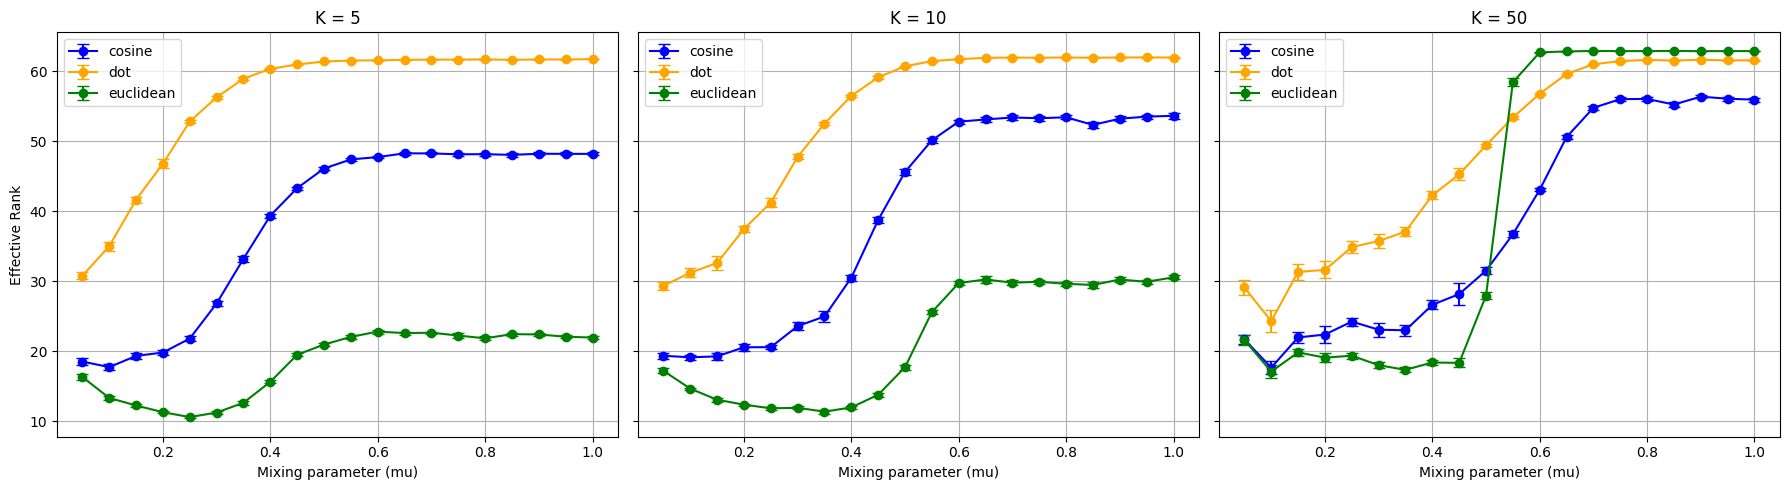

In [52]:
color_map = {"cosine": "blue", "dot": "orange", "euclidean": "green"}

# Plotting with error bars: one subplot per K value.
import matplotlib.pyplot as plt

K_unique = sorted(agg_results['K'].unique())
etype_unique = sorted(agg_results['embedding_type'].unique())

fig, axes = plt.subplots(1, len(K_unique), figsize=(18, 5), sharey=True)

for ax, K in zip(axes, K_unique):
    df_K = agg_results[agg_results['K'] == K]
    for etype in etype_unique:
        df_type = df_K[df_K['embedding_type'] == etype]
        ax.errorbar(
            df_type['mu'], 
            df_type['mean'], 
            yerr=df_type['se'], 
            marker='o', 
            capsize=4, 
            label=etype,
            color=color_map[etype]
        )
    ax.set_title(f"K = {K}")
    ax.set_xlabel("Mixing parameter (mu)")
    ax.grid(True)
    ax.legend()
axes[0].set_ylabel("Effective Rank")
plt.tight_layout()
plt.show()


Can we find the detectability limit using this? Even without clustering?

# We notice the same pattern in the PCA explained variance metric also

In [ ]:
import numpy as np
import pandas as pd
import pickle
from scipy import sparse
import matplotlib.pyplot as plt
from tqdm import tqdm

def load_net_and_embedding(net_filename, comm_filename, emb_filename):
    net = sparse.load_npz(net_filename)
    community_table = pd.read_csv(comm_filename)
    with open(emb_filename, 'rb') as f:
        emb_dict = pickle.load(f)
    return net, community_table, emb_dict

def process_run(run_no, mu, K):
    path_name = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_n2v_metric_change_10000_{K}_3.0_minc50/Run_{run_no}/"
    net_filename = path_name + f"net_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu}_k_{K}_mincomm_50.npz"
    comm_filename = path_name + f"community_table_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu}_k_{K}_mincomm_50.csv"
    emb_filename = path_name + f"embeddings_LFR_n_10000_tau1_3.0_tau2_1.0_mu_{mu}_k_{K}_mincomm_50.pkl"
    
    net, community_table, emb_dict = load_net_and_embedding(net_filename, comm_filename, emb_filename)
    return net, community_table, emb_dict

def pca_intrinsic_dim(X, variance_threshold=0.95):
    """
    Compute the intrinsic dimension using PCA.
    Returns the smallest number of principal components needed to reach the given variance threshold.
    """
    X_centered = X - np.mean(X, axis=0)
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    explained_variance = (S**2) / np.sum(S**2)
    cumulative_variance = np.cumsum(explained_variance)
    intrinsic_dim = np.searchsorted(cumulative_variance, variance_threshold) + 1
    return intrinsic_dim

# Define parameters
mu_values = np.round(np.arange(0.05, 1.05, 0.05), decimals=2)
K_values = [5, 10, 50]
embedding_types = ['dot', 'euclidean', 'cosine']
num_runs = 10

# We'll store the raw intrinsic dimension values for each run.
# Structure: raw_pca_results[K][etype][mu] will be a list of intrinsic dimensions (one per run).
raw_pca_results = {
    K: {etype: {mu: [] for mu in mu_values} for etype in embedding_types} 
    for K in K_values
}

# Loop over each K, each μ, and each run.
for K in tqdm(K_values, desc="Processing K values for PCA"):
    for mu in tqdm(mu_values, desc=f"Processing mu for K={K}", leave=False):
        for run_no in tqdm(range(1, num_runs + 1), desc=f"Processing runs for mu={mu}, K={K}", leave=False):
            try:
                _, _, emb_dict = process_run(run_no, mu, K)
                if not emb_dict:
                    tqdm.write(f"emb_dict empty for run {run_no} (mu={mu}, K={K}); skipping run.")
                    # Record NaN for each embedding type.
                    for etype in embedding_types:
                        raw_pca_results[K][etype][mu].append(np.nan)
                    continue
                for etype in embedding_types:
                    try:
                        intrinsic_dim = pca_intrinsic_dim(emb_dict[etype], variance_threshold=0.95)
                    except Exception as e:
                        tqdm.write(f"Error computing intrinsic dim for run {run_no}, mu {mu}, K {K}, type {etype}: {e}")
                        intrinsic_dim = np.nan
                    raw_pca_results[K][etype][mu].append(intrinsic_dim)
            except Exception as e:
                tqdm.write(f"Error processing run {run_no} for mu {mu} and K {K}: {e}")
                for etype in embedding_types:
                    raw_pca_results[K][etype][mu].append(np.nan)

# Now, compute the aggregated mean and standard error for each K, μ, and embedding type.
pca_agg_results = {K: {etype: {'mean': [], 'se': []} for etype in embedding_types} for K in K_values}

for K in K_values:
    for etype in embedding_types:
        for mu in mu_values:
            values = np.array(raw_pca_results[K][etype][mu])
            valid = ~np.isnan(values)
            if valid.sum() > 0:
                mean_val = np.mean(values[valid])
                se_val = np.std(values[valid], ddof=1) / np.sqrt(valid.sum())
            else:
                mean_val = np.nan
                se_val = np.nan
            pca_agg_results[K][etype]['mean'].append(mean_val)
            pca_agg_results[K][etype]['se'].append(se_val)

Processing K values for PCA:   0%| | 0/3 
Processing mu for K=5:   0%| | 0/20 [00:0

Processing runs for mu=0.05, K=5:   0%| |

Processing runs for mu=0.05, K=5:  10%| |

Processing runs for mu=0.05, K=5:  20%|▏|

Processing runs for mu=0.05, K=5:  30%|▎|

Processing runs for mu=0.05, K=5:  40%|▍|

Processing runs for mu=0.05, K=5:  50%|▌|

Processing runs for mu=0.05, K=5:  60%|▌|

Processing runs for mu=0.05, K=5:  70%|▋|

Processing runs for mu=0.05, K=5:  80%|▊|

Processing runs for mu=0.05, K=5:  90%|▉|

Processing runs for mu=0.05, K=5: 100%|█|

                                         
Processing mu for K=5:   5%| | 1/20 [00:0

Processing runs for mu=0.1, K=5:   0%| | 

Processing runs for mu=0.1, K=5:  10%| | 

Processing runs for mu=0.1, K=5:  20%|▏| 

Processing runs for mu=0.1, K=5:  30%|▎| 

Processing runs for mu=0.1, K=5:  40%|▍| 

Processing runs for mu=0.1, K=5:  50%|▌| 

Processing runs for mu=0.1, K=5:  60%|▌| 

Processing runs for mu=0.1, K=5:  70%|▋| 

Processing ru

emb_dict empty for run 4 (mu=0.05, K=10); skipping run.
emb_dict empty for run 6 (mu=0.05, K=10); skipping run.
emb_dict empty for run 7 (mu=0.05, K=10); skipping run.


Processing runs for mu=0.05, K=10:  50%|▌

                                         
                                      

Processing K values for PCA:  33%|▎| 1/3 
Processing mu for K=10:   0%| | 0/20 [00:

Processing runs for mu=0.05, K=10:  80%|▊

Processing runs for mu=0.05, K=10: 100%|█

                                         
Processing mu for K=10:   5%| | 1/20 [00:

emb_dict empty for run 10 (mu=0.05, K=10); skipping run.




Processing runs for mu=0.1, K=10:   0%| |

Processing runs for mu=0.1, K=10:  10%| |

Processing runs for mu=0.1, K=10:  20%|▏|

Processing runs for mu=0.1, K=10:  30%|▎|

Processing runs for mu=0.1, K=10:  40%|▍|

Processing runs for mu=0.1, K=10:  50%|▌|

Processing runs for mu=0.1, K=10:  60%|▌|

Processing runs for mu=0.1, K=10:  70%|▋|

Processing runs for mu=0.1, K=10:  80%|▊|

Processing runs for mu=0.1, K=10:  90%|▉|

Processing runs for mu=0.1, K=10: 100%|█|

                                         
Processing mu for K=10:  10%| | 2/20 [00:

Processing runs for mu=0.15, K=10:   0%| 

Processing runs for mu=0.15, K=10:  10%| 

Processing runs for mu=0.15, K=10:  20%|▏

Processing runs for mu=0.15, K=10:  30%|▎

Processing runs for mu=0.15, K=10:  40%|▍

Processing runs for mu=0.15, K=10:  50%|▌

Processing runs for mu=0.15, K=10:  60%|▌

Processing runs for mu=0.15, K=10:  70%|▋

Processing runs for mu=0.15, K=10:  80%|▊

Processing runs for mu=0.15, K=10:  90%|▉

Processing

emb_dict empty for run 3 (mu=0.25, K=10); skipping run.
emb_dict empty for run 4 (mu=0.25, K=10); skipping run.
emb_dict empty for run 5 (mu=0.25, K=10); skipping run.
emb_dict empty for run 7 (mu=0.25, K=10); skipping run.


                                         
                                      

Processing K values for PCA:  33%|▎| 1/3 
Processing mu for K=10:  20%|▏| 4/20 [00:

                                         
                                      

Processing K values for PCA:  33%|▎| 1/3 
Processing mu for K=10:  20%|▏| 4/20 [00:

Processing runs for mu=0.25, K=10:  60%|▌

Processing runs for mu=0.25, K=10: 100%|█

                                         
Processing mu for K=10:  25%|▎| 5/20 [00:

emb_dict empty for run 8 (mu=0.25, K=10); skipping run.
emb_dict empty for run 9 (mu=0.25, K=10); skipping run.




Processing runs for mu=0.3, K=10:   0%| |

Processing runs for mu=0.3, K=10:  10%| |

Processing runs for mu=0.3, K=10:  20%|▏|

Processing runs for mu=0.3, K=10:  30%|▎|

Processing runs for mu=0.3, K=10:  40%|▍|

Processing runs for mu=0.3, K=10:  50%|▌|

Processing runs for mu=0.3, K=10:  60%|▌|

Processing runs for mu=0.3, K=10:  70%|▋|

Processing runs for mu=0.3, K=10:  80%|▊|

Processing runs for mu=0.3, K=10:  90%|▉|

Processing runs for mu=0.3, K=10: 100%|█|

                                         
Processing mu for K=10:  30%|▎| 6/20 [00:

Processing runs for mu=0.35, K=10:   0%| 

Processing runs for mu=0.35, K=10:  10%| 

Processing runs for mu=0.35, K=10:  20%|▏

Processing runs for mu=0.35, K=10:  30%|▎

Processing runs for mu=0.35, K=10:  40%|▍

Processing runs for mu=0.35, K=10:  50%|▌

Processing runs for mu=0.35, K=10:  60%|▌

Processing runs for mu=0.35, K=10:  70%|▋

Processing runs for mu=0.35, K=10:  80%|▊

Processing runs for mu=0.35, K=10:  90%|▉

Processing

emb_dict empty for run 4 (mu=0.45, K=10); skipping run.
emb_dict empty for run 5 (mu=0.45, K=10); skipping run.
emb_dict empty for run 6 (mu=0.45, K=10); skipping run.


                                         
                                      

Processing K values for PCA:  33%|▎| 1/3 
Processing mu for K=10:  40%|▍| 8/20 [00:

Processing runs for mu=0.45, K=10:  70%|▋

                                         
                                      

Processing K values for PCA:  33%|▎| 1/3 
Processing mu for K=10:  40%|▍| 8/20 [00:

Processing runs for mu=0.45, K=10:  90%|▉

                                         
Processing mu for K=10:  45%|▍| 9/20 [00:

emb_dict empty for run 9 (mu=0.45, K=10); skipping run.
emb_dict empty for run 10 (mu=0.45, K=10); skipping run.




Processing runs for mu=0.5, K=10:   0%| |

Processing runs for mu=0.5, K=10:  10%| |

Processing runs for mu=0.5, K=10:  20%|▏|

Processing runs for mu=0.5, K=10:  30%|▎|

Processing runs for mu=0.5, K=10:  40%|▍|

Processing runs for mu=0.5, K=10:  50%|▌|

Processing runs for mu=0.5, K=10:  60%|▌|

Processing runs for mu=0.5, K=10:  70%|▋|

Processing runs for mu=0.5, K=10:  80%|▊|

Processing runs for mu=0.5, K=10:  90%|▉|

Processing runs for mu=0.5, K=10: 100%|█|

                                         
Processing mu for K=10:  50%|▌| 10/20 [00

Processing runs for mu=0.55, K=10:   0%| 

Processing runs for mu=0.55, K=10:  10%| 

Processing runs for mu=0.55, K=10:  20%|▏

Processing runs for mu=0.55, K=10:  30%|▎

Processing runs for mu=0.55, K=10:  40%|▍

Processing runs for mu=0.55, K=10:  50%|▌

Processing runs for mu=0.55, K=10:  60%|▌

Processing runs for mu=0.55, K=10:  70%|▋

Processing runs for mu=0.55, K=10:  80%|▊

Processing runs for mu=0.55, K=10:  90%|▉

Processing

emb_dict empty for run 2 (mu=0.65, K=10); skipping run.
emb_dict empty for run 3 (mu=0.65, K=10); skipping run.
emb_dict empty for run 4 (mu=0.65, K=10); skipping run.




                                         
                                      

Processing K values for PCA:  33%|▎| 1/3 
Processing mu for K=10:  60%|▌| 12/20 [00

Processing runs for mu=0.65, K=10:  70%|▋

                                         
                                      

Processing K values for PCA:  33%|▎| 1/3 
Processing mu for K=10:  60%|▌| 12/20 [00

Processing runs for mu=0.65, K=10:  90%|▉

                                         
Processing mu for K=10:  65%|▋| 13/20 [00

emb_dict empty for run 8 (mu=0.65, K=10); skipping run.
emb_dict empty for run 10 (mu=0.65, K=10); skipping run.




Processing runs for mu=0.7, K=10:   0%| |

Processing runs for mu=0.7, K=10:  10%| |

Processing runs for mu=0.7, K=10:  20%|▏|

Processing runs for mu=0.7, K=10:  30%|▎|

Processing runs for mu=0.7, K=10:  40%|▍|

Processing runs for mu=0.7, K=10:  50%|▌|

Processing runs for mu=0.7, K=10:  60%|▌|

Processing runs for mu=0.7, K=10:  70%|▋|

Processing runs for mu=0.7, K=10:  80%|▊|

Processing runs for mu=0.7, K=10:  90%|▉|

Processing runs for mu=0.7, K=10: 100%|█|

                                         
Processing mu for K=10:  70%|▋| 14/20 [00

Processing runs for mu=0.75, K=10:   0%| 

Processing runs for mu=0.75, K=10:  10%| 

Processing runs for mu=0.75, K=10:  20%|▏

Processing runs for mu=0.75, K=10:  30%|▎

Processing runs for mu=0.75, K=10:  40%|▍

Processing runs for mu=0.75, K=10:  50%|▌

Processing runs for mu=0.75, K=10:  60%|▌

Processing runs for mu=0.75, K=10:  70%|▋

Processing runs for mu=0.75, K=10:  80%|▊

Processing runs for mu=0.75, K=10:  90%|▉

Processing

emb_dict empty for run 2 (mu=0.85, K=10); skipping run.


                                         
                                      

Processing K values for PCA:  33%|▎| 1/3 
Processing mu for K=10:  80%|▊| 16/20 [00

Processing runs for mu=0.85, K=10:  30%|▎

                                         
                                      

Processing K values for PCA:  33%|▎| 1/3 
Processing mu for K=10:  80%|▊| 16/20 [00

Processing runs for mu=0.85, K=10:  50%|▌

                                         
                                      

Processing K values for PCA:  33%|▎| 1/3 
Processing mu for K=10:  80%|▊| 16/20 [00

                                         
                                      

                                         

emb_dict empty for run 5 (mu=0.85, K=10); skipping run.
emb_dict empty for run 6 (mu=0.85, K=10); skipping run.
emb_dict empty for run 8 (mu=0.85, K=10); skipping run.


Processing K values for PCA:  33%|▎| 1/3 
Processing mu for K=10:  80%|▊| 16/20 [00

                                         
                                      

Processing K values for PCA:  33%|▎| 1/3 
Processing mu for K=10:  80%|▊| 16/20 [00

Processing runs for mu=0.85, K=10:  70%|▋

                                         
Processing mu for K=10:  85%|▊| 17/20 [00

emb_dict empty for run 9 (mu=0.85, K=10); skipping run.
emb_dict empty for run 10 (mu=0.85, K=10); skipping run.




Processing runs for mu=0.9, K=10:   0%| |

Processing runs for mu=0.9, K=10:  10%| |

Processing runs for mu=0.9, K=10:  20%|▏|

Processing runs for mu=0.9, K=10:  30%|▎|

Processing runs for mu=0.9, K=10:  40%|▍|

Processing runs for mu=0.9, K=10:  50%|▌|

Processing runs for mu=0.9, K=10:  60%|▌|

Processing runs for mu=0.9, K=10:  70%|▋|

Processing runs for mu=0.9, K=10:  80%|▊|

Processing runs for mu=0.9, K=10:  90%|▉|

Processing runs for mu=0.9, K=10: 100%|█|

                                         
Processing mu for K=10:  90%|▉| 18/20 [00

Processing runs for mu=0.95, K=10:   0%| 

Processing runs for mu=0.95, K=10:  10%| 

Processing runs for mu=0.95, K=10:  20%|▏

Processing runs for mu=0.95, K=10:  30%|▎

Processing runs for mu=0.95, K=10:  40%|▍

Processing runs for mu=0.95, K=10:  50%|▌

Processing runs for mu=0.95, K=10:  60%|▌

Processing runs for mu=0.95, K=10:  70%|▋

Processing runs for mu=0.95, K=10:  80%|▊

Processing runs for mu=0.95, K=10:  90%|▉

Processing

emb_dict empty for run 4 (mu=0.05, K=50); skipping run.




                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:   0%| | 0/20 [00:

Processing runs for mu=0.05, K=50:  60%|▌

Processing runs for mu=0.05, K=50:  80%|▊

emb_dict empty for run 7 (mu=0.05, K=50); skipping run.




                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:   0%| | 0/20 [00:

Processing runs for mu=0.05, K=50:  90%|▉

                                         
Processing mu for K=50:   5%| | 1/20 [00:

emb_dict empty for run 10 (mu=0.05, K=50); skipping run.




Processing runs for mu=0.1, K=50:   0%| |

Processing runs for mu=0.1, K=50:  10%| |

Processing runs for mu=0.1, K=50:  20%|▏|

Processing runs for mu=0.1, K=50:  30%|▎|

Processing runs for mu=0.1, K=50:  40%|▍|

Processing runs for mu=0.1, K=50:  50%|▌|

Processing runs for mu=0.1, K=50:  60%|▌|

Processing runs for mu=0.1, K=50:  70%|▋|

Processing runs for mu=0.1, K=50:  80%|▊|

Processing runs for mu=0.1, K=50:  90%|▉|

Processing runs for mu=0.1, K=50: 100%|█|

                                         
Processing mu for K=50:  10%| | 2/20 [00:

Processing runs for mu=0.15, K=50:   0%| 

Processing runs for mu=0.15, K=50:  10%| 

Processing runs for mu=0.15, K=50:  20%|▏

Processing runs for mu=0.15, K=50:  30%|▎

Processing runs for mu=0.15, K=50:  40%|▍

Processing runs for mu=0.15, K=50:  50%|▌

Processing runs for mu=0.15, K=50:  60%|▌

Processing runs for mu=0.15, K=50:  70%|▋

Processing runs for mu=0.15, K=50:  80%|▊

Processing runs for mu=0.15, K=50:  90%|▉

Processing

emb_dict empty for run 3 (mu=0.25, K=50); skipping run.
emb_dict empty for run 4 (mu=0.25, K=50); skipping run.
emb_dict empty for run 5 (mu=0.25, K=50); skipping run.
emb_dict empty for run 6 (mu=0.25, K=50); skipping run.
emb_dict empty for run 7 (mu=0.25, K=50); skipping run.




                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:  20%|▏| 4/20 [00:

Processing runs for mu=0.25, K=50:  80%|▊

Processing runs for mu=0.25, K=50: 100%|█

                                         
Processing mu for K=50:  25%|▎| 5/20 [00:

emb_dict empty for run 9 (mu=0.25, K=50); skipping run.




Processing runs for mu=0.3, K=50:   0%| |

Processing runs for mu=0.3, K=50:  10%| |

Processing runs for mu=0.3, K=50:  20%|▏|

Processing runs for mu=0.3, K=50:  30%|▎|

Processing runs for mu=0.3, K=50:  40%|▍|

Processing runs for mu=0.3, K=50:  50%|▌|

Processing runs for mu=0.3, K=50:  60%|▌|

Processing runs for mu=0.3, K=50:  70%|▋|

Processing runs for mu=0.3, K=50:  80%|▊|

Processing runs for mu=0.3, K=50:  90%|▉|

Processing runs for mu=0.3, K=50: 100%|█|

                                         
Processing mu for K=50:  30%|▎| 6/20 [00:

Processing runs for mu=0.35, K=50:   0%| 

Processing runs for mu=0.35, K=50:  10%| 

Processing runs for mu=0.35, K=50:  20%|▏

Processing runs for mu=0.35, K=50:  30%|▎

Processing runs for mu=0.35, K=50:  40%|▍

Processing runs for mu=0.35, K=50:  50%|▌

Processing runs for mu=0.35, K=50:  60%|▌

Processing runs for mu=0.35, K=50:  70%|▋

Processing runs for mu=0.35, K=50:  80%|▊

Processing runs for mu=0.35, K=50:  90%|▉

Processing

emb_dict empty for run 3 (mu=0.45, K=50); skipping run.
emb_dict empty for run 5 (mu=0.45, K=50); skipping run.


                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:  40%|▍| 8/20 [00:

Processing runs for mu=0.45, K=50:  40%|▍

Processing runs for mu=0.45, K=50:  70%|▋

emb_dict empty for run 6 (mu=0.45, K=50); skipping run.


                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:  40%|▍| 8/20 [00:

Processing runs for mu=0.45, K=50:  70%|▋

                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:  40%|▍| 8/20 [00:

Processing runs for mu=0.45, K=50:  90%|▉

                                         
Processing mu for K=50:  45%|▍| 9/20 [00:

emb_dict empty for run 9 (mu=0.45, K=50); skipping run.
emb_dict empty for run 10 (mu=0.45, K=50); skipping run.




Processing runs for mu=0.5, K=50:   0%| |

Processing runs for mu=0.5, K=50:  10%| |

Processing runs for mu=0.5, K=50:  20%|▏|

Processing runs for mu=0.5, K=50:  30%|▎|

Processing runs for mu=0.5, K=50:  40%|▍|

Processing runs for mu=0.5, K=50:  50%|▌|

Processing runs for mu=0.5, K=50:  60%|▌|

Processing runs for mu=0.5, K=50:  70%|▋|

Processing runs for mu=0.5, K=50:  80%|▊|

Processing runs for mu=0.5, K=50:  90%|▉|

Processing runs for mu=0.5, K=50: 100%|█|

                                         
Processing mu for K=50:  50%|▌| 10/20 [00

Processing runs for mu=0.55, K=50:   0%| 

Processing runs for mu=0.55, K=50:  10%| 

Processing runs for mu=0.55, K=50:  20%|▏

Processing runs for mu=0.55, K=50:  30%|▎

Processing runs for mu=0.55, K=50:  40%|▍

Processing runs for mu=0.55, K=50:  50%|▌

Processing runs for mu=0.55, K=50:  60%|▌

Processing runs for mu=0.55, K=50:  70%|▋

Processing runs for mu=0.55, K=50:  80%|▊

Processing runs for mu=0.55, K=50:  90%|▉

Processing

emb_dict empty for run 2 (mu=0.65, K=50); skipping run.
emb_dict empty for run 4 (mu=0.65, K=50); skipping run.




                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:  60%|▌| 12/20 [00

                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:  60%|▌| 12/20 [00

Processing runs for mu=0.65, K=50:  50%|▌

Processing runs for mu=0.65, K=50:  80%|▊

emb_dict empty for run 6 (mu=0.65, K=50); skipping run.
emb_dict empty for run 7 (mu=0.65, K=50); skipping run.


                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:  60%|▌| 12/20 [00

Processing runs for mu=0.65, K=50:  80%|▊

Processing runs for mu=0.65, K=50: 100%|█

                                         
Processing mu for K=50:  65%|▋| 13/20 [00

emb_dict empty for run 10 (mu=0.65, K=50); skipping run.




Processing runs for mu=0.7, K=50:   0%| |

Processing runs for mu=0.7, K=50:  10%| |

Processing runs for mu=0.7, K=50:  20%|▏|

Processing runs for mu=0.7, K=50:  30%|▎|

Processing runs for mu=0.7, K=50:  40%|▍|

Processing runs for mu=0.7, K=50:  50%|▌|

Processing runs for mu=0.7, K=50:  60%|▌|

Processing runs for mu=0.7, K=50:  70%|▋|

Processing runs for mu=0.7, K=50:  80%|▊|

Processing runs for mu=0.7, K=50:  90%|▉|

Processing runs for mu=0.7, K=50: 100%|█|

                                         
Processing mu for K=50:  70%|▋| 14/20 [00

Processing runs for mu=0.75, K=50:   0%| 

Processing runs for mu=0.75, K=50:  10%| 

Processing runs for mu=0.75, K=50:  20%|▏

Processing runs for mu=0.75, K=50:  30%|▎

Processing runs for mu=0.75, K=50:  40%|▍

Processing runs for mu=0.75, K=50:  50%|▌

Processing runs for mu=0.75, K=50:  60%|▌

Processing runs for mu=0.75, K=50:  70%|▋

Processing runs for mu=0.75, K=50:  80%|▊

Processing runs for mu=0.75, K=50:  90%|▉

Processing

emb_dict empty for run 2 (mu=0.85, K=50); skipping run.
emb_dict empty for run 4 (mu=0.85, K=50); skipping run.


                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:  80%|▊| 16/20 [00

Processing runs for mu=0.85, K=50:  30%|▎

                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:  80%|▊| 16/20 [00

Processing runs for mu=0.85, K=50:  60%|▌

emb_dict empty for run 5 (mu=0.85, K=50); skipping run.
emb_dict empty for run 7 (mu=0.85, K=50); skipping run.


                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:  80%|▊| 16/20 [00

                                         
                                      

Processing K values for PCA:  67%|▋| 2/3 
Processing mu for K=50:  80%|▊| 16/20 [00

Processing runs for mu=0.85, K=50:  60%|▌

Processing runs for mu=0.85, K=50:  90%|▉

                                         
Processing mu for K=50:  85%|▊| 17/20 [00

emb_dict empty for run 8 (mu=0.85, K=50); skipping run.
emb_dict empty for run 9 (mu=0.85, K=50); skipping run.




Processing runs for mu=0.9, K=50:   0%| |

Processing runs for mu=0.9, K=50:  10%| |

Processing runs for mu=0.9, K=50:  20%|▏|

Processing runs for mu=0.9, K=50:  30%|▎|

Processing runs for mu=0.9, K=50:  40%|▍|

Processing runs for mu=0.9, K=50:  50%|▌|

Processing runs for mu=0.9, K=50:  60%|▌|

Processing runs for mu=0.9, K=50:  70%|▋|

Processing runs for mu=0.9, K=50:  80%|▊|

Processing runs for mu=0.9, K=50:  90%|▉|

Processing runs for mu=0.9, K=50: 100%|█|

                                         
Processing mu for K=50:  90%|▉| 18/20 [00

Processing runs for mu=0.95, K=50:   0%| 

Processing runs for mu=0.95, K=50:  10%| 

Processing runs for mu=0.95, K=50:  20%|▏

Processing runs for mu=0.95, K=50:  30%|▎

Processing runs for mu=0.95, K=50:  40%|▍

Processing runs for mu=0.95, K=50:  50%|▌

Processing runs for mu=0.95, K=50:  60%|▌

Processing runs for mu=0.95, K=50:  70%|▋

Processing runs for mu=0.95, K=50:  80%|▊

Processing runs for mu=0.95, K=50:  90%|▉

Processing

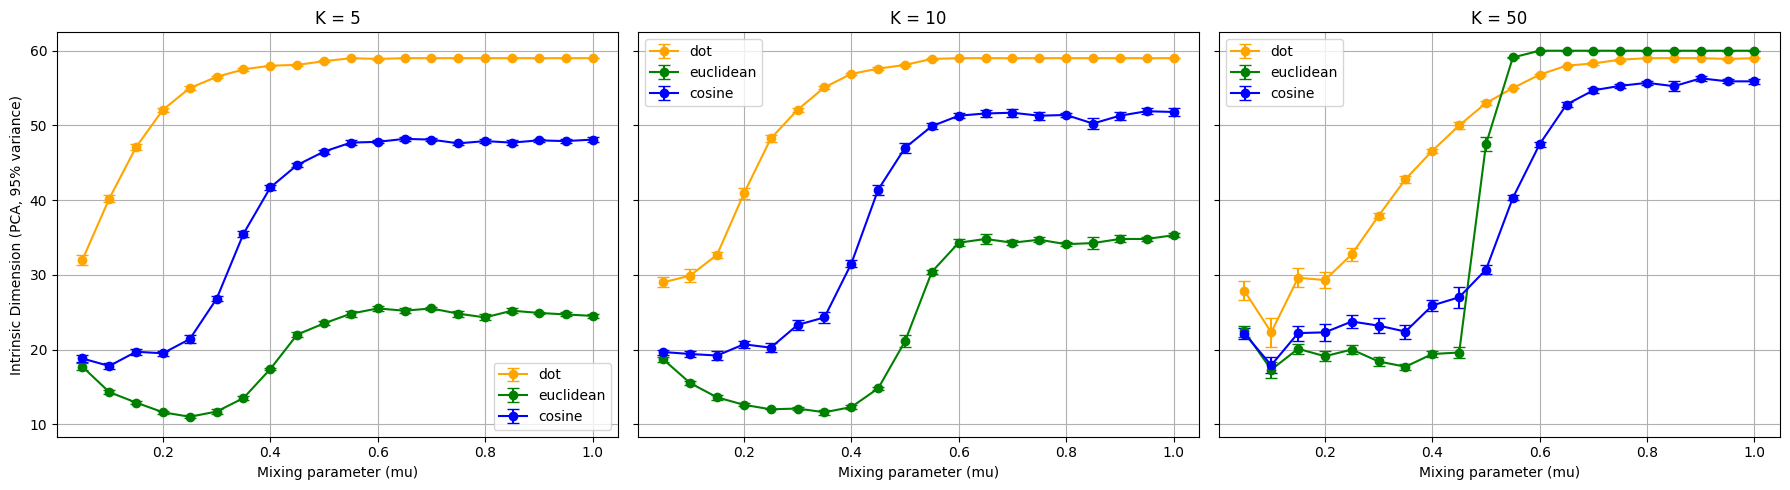

In [51]:
# Define a color map for consistency.
color_map = {"cosine": "blue", "dot": "orange", "euclidean": "green"}

# Plot with error bars: one subplot per K value.
fig, axes = plt.subplots(1, len(K_values), figsize=(18, 5), sharey=True)
for ax, K in zip(axes, K_values):
    for etype in embedding_types:
        means = np.array(pca_agg_results[K][etype]['mean'])
        ses = np.array(pca_agg_results[K][etype]['se'])
        ax.errorbar(
            mu_values, 
            means, 
            yerr=ses, 
            marker='o', 
            capsize=4, 
            label=etype, 
            color=color_map[etype]
        )
    ax.set_title(f"K = {K}")
    ax.set_xlabel("Mixing parameter (mu)")
    ax.grid(True)
    ax.legend()
axes[0].set_ylabel("Intrinsic Dimension (PCA, 95% variance)")
plt.tight_layout()
plt.show()
